In [1]:
!ls /keyakizaka_mining/data/

Icon?	 faceimages		 feature     profile		test
blog	 faceimages_pad0	 images      ref		tweet
dataset  faceimages_pad0_resize  images.zip  rename_test.ipynb


In [2]:
# path
keyaki_dict_path = '/keyakizaka_mining/data/ref/user_keyakizaka_v2.dic'
blog_save_dir = '/keyakizaka_mining/data/blog'
save_tweet_path =  "/keyakizaka_mining/data/tweet"
graph_save_dir = "/keyakizaka_mining/result/blog_graph/"
font_path = "/usr/share/fonts/truetype/takao-gothic/TakaoGothic.ttf"

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

import networkx as nx
%config InlineBackend.figure_format = 'retina'

In [4]:

import MeCab
# mecab = MeCab.Tagger("-Ochasen")
mecab = MeCab.Tagger (r"-Ochasen -u %s" % keyaki_dict_path)
mecab.parseToNode( '' )

<MeCab.Node; proxy of <Swig Object of type 'MeCab::Node *' at 0x7f4ee405d0f0> >

In [5]:
# japanese plot setting

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

font_prop = FontProperties(fname=font_path)
mpl.rcParams['font.family'] = font_prop.get_name()

In [6]:
def get_member_words( text ):
    
    if type(text) != str: return [] 
    
    tokens = []
    result = mecab.parseToNode( text )
    while result:
        line = result.feature.split(',')
        tag = line[-1]
        if 'keyakizaka' in tag:
            tokens.append( [result.surface, tag] )
        result = result.next
    return tokens

In [7]:
get_member_words( '''
みなさんこんにちは٩( ᐛ )و

日向坂46の丹生明里(にぶ あかり)です

でもコンタクトって本当に便利ですよね！！！
わたしは中学卒業してからの春休みに出会ったのですが、人生が大きく変わりました！
いつまでコンタクトさんにお世話になるかな〜！

コンタクトで思い出したのですが、舞台マギアレコードの時はピンク色のコンタクトを入れていました！
またピンクになりたいな〜

''')

[['丹生明里', 'keyakizaka_nibu'],
 ['にぶ', 'keyakizaka_nibu'],
 ['あかり', 'keyakizaka_nibu']]

In [8]:
def extract_df_date_range(df_tmp, start, end):
    df_tmp['datetime'] = pd.to_datetime( df_tmp['datetime'], format='%Y.%m.%d %H:%M' )
    df_tmp = df_tmp.set_index('datetime')
    df_tmp = df_tmp.loc[start:end]
    return df_tmp

In [9]:
def get_relation( df  ): 
    mat = np.zeros( ( len(target_members), len(target_members)) )
    for i, t in enumerate( df[['author', 'text']].values.tolist()):    
        memtags = get_member_words(t[1])
        if len( memtags ) == 0: continue
        atag = author2tag[t[0]]
        memtags_rm = [ i[1] for i in memtags if i[1] != atag]
        for inmem in memtags_rm:
            if not inmem in target_members: continue
            mat[mem2idx[atag], mem2idx[inmem]] += 1.0
    
    dfmat = pd.DataFrame( mat, index=target_members_name, columns=target_members_name )
    dfmat.index.name = 'from'
    dfmat.columns.name = 'to'
    return dfmat

In [10]:
def from_mms_for_df( df ):
    mms = MinMaxScaler()
    df_mms = pd.DataFrame( mms.fit_transform( df ), index=target_members_name, columns=target_members_name )
    # df_mms = pd.DataFrame( mms.fit_transform( df.T ).T, index=target_members_name, columns=target_members_name )
    df_mms.index.name = 'from'
    df_mms.columns.name = 'to'
    return df_mms

def to_mms_for_df( df ):
    mms = MinMaxScaler()
    df_mms = pd.DataFrame( mms.fit_transform( df.T ).T, index=target_members_name, columns=target_members_name )
    df_mms.index.name = 'from'
    df_mms.columns.name = 'to'
    return df_mms


def chech_heatmap(df):
    plt.figure( figsize=(12, 9), dpi=100 ) 
    sns.heatmap(df, annot=True, fmt="1.0f", linewidths=.5, cmap="Blues")
    #plt.savefig('tmp.png')
    plt.show()
    return

def chech_heatmap_normarize(df):
    plt.figure( figsize=(12, 9), dpi=100 ) 
    sns.heatmap(df, annot=True, fmt="1.2f", linewidths=.5, cmap="Blues")
    #plt.savefig('tmp.png')
    plt.show()
    return

In [11]:
# gdf file ( Gephi )
def get_gdf_from_networkX( G, fpath ):
    f = open( fpath, 'w', encoding='shift-jis', errors='ignore' )
    # node
    f.write( 'nodedef>name VARCHAR,label VARCHAR,\n')
    name2idx = { name:i for i, name in enumerate( G.nodes )}
    for i, name in enumerate( G.nodes ):
        f.write('%d,%s,\n' % ( i, name ) )

    # edge
    f.write( 'edgedef>node1 VARCHAR,node2 VARCHAR,weight DOUBLE\n' )
    for e in G.edges(data=True):
        f.write('%d,%d,%.3f\n' % (name2idx[e[0]], name2idx[e[1]], e[2]['weight']) )
    f.close()
    
# gml file ( cytoscape )    
def get_gml_from_networkX( G, fpath ):
    f = open( fpath, 'w', encoding='utf-8', errors='ignore' )
    f.write('graph [')
    # node
    name2idx = { name:i for i, name in enumerate( G.nodes )}
    for name, i in name2idx.items():
        f.write('''
          node [
            id %d
            label "%s"
          ]'''
        % ( i, name ))
    
    # edge
    for e in G.edges(data=True):
        f.write('''
          edge [
            source %d
            target %d
            weight %.3f
          ]'''
        % (name2idx[e[0]], name2idx[e[1]], e[2]['weight']) )  
    
    f.write('\n]')
    f.close()   

In [12]:
# read blog data

df = pd.read_csv( '%s/hinatazaka46_blog_20190726.csv' % (blog_save_dir) )
print( df.shape )
df.head() 

(8529, 6)


,author,datetime,title,text,images,url
0,加藤史帆,2016.8.2 02:50,はじめまして( 。・о・。),はじめまして！ ひらがなけやきの加藤史帆です(｡･υ･)/ﾞ 今月から私たちひ...,https://cdn.hinatazaka46.com/images/14/aff/ed5...,https://www.hinatazaka46.com/s/official/diary/...
1,高本彩花,2016.8.2 02:46,はじめまして,はじめまして ひらがなけやきの高本彩花です。 8月からブログ書かせていただけることに...,https://cdn.hinatazaka46.com/images/14/913/41e...,https://www.hinatazaka46.com/s/official/diary/...
2,潮紗理菜,2016.8.2 02:45,こんばんは！はじめまして！よろしくお願い致します！,みなさんはじめまして。潮紗理菜です！ 今日からブログを書かせていただくことになりました。！ ...,https://cdn.hinatazaka46.com/images/14/775/def...,https://www.hinatazaka46.com/s/official/diary/...
3,高瀬愛奈,2016.8.2 02:44,はじめまして、高瀬愛奈です☆,皆さん、はじめまして！ 高瀬愛奈です。 今日からブログを始めさせていただけることになりまし...,https://cdn.hinatazaka46.com/images/14/00e/086...,https://www.hinatazaka46.com/s/official/diary/...
4,柿崎芽実,2016.8.2 02:42,こんばんは(・∀・)ﾉ,みなさんこんばんは！ けやき坂46の柿崎芽実です。\nついにブログ始まりました！ これからで...,https://cdn.hinatazaka46.com/files/14/diary/k4...,https://www.hinatazaka46.com/s/official/diary/...


In [13]:
df.tail()

,author,datetime,title,text,images,url
8524,齊藤京子,2019.7.24 16:21,スマートニュース,7月22日から私たちが出演しているスマートニュースの新テレビCMが放送開始します\( ¨̮ ...,https://cdn.hinatazaka46.com/files/14/diary/of...,https://www.hinatazaka46.com/s/official/diary/...
8525,松田好花,2019.7.24 00:50,デマーシア！,こんばんは！日向坂46 松田好花です😚今日は丹生ちゃんと卓志ぃぃeeeee！さんに出演させて...,https://cdn.hinatazaka46.com/files/14/diary/of...,https://www.hinatazaka46.com/s/official/diary/...
8526,富田鈴花,2019.7.24 00:49,7月28日,こんにちは！日向坂46の富田鈴花です🐘ブログにのっけようって思った写真はお気に入りフォルダに...,https://cdn.hinatazaka46.com/files/14/diary/of...,https://www.hinatazaka46.com/s/official/diary/...
8527,高本彩花,2019.7.23 23:19,🍒,こんにちは高本彩花です🍒🧜‍♀️先日、MUSIC STATIONさんに出演しました🎤キュンに...,https://cdn.hinatazaka46.com/files/14/diary/of...,https://www.hinatazaka46.com/s/official/diary/...
8528,上村ひなの,2019.7.23 23:17,"69,ゼラニウムの葉",こんにちは！\n\n\n日向坂46三期生\n中学三年生15歳の\n\nかみむら ひなの です...,https://cdn.hinatazaka46.com/images/14/6c6/b89...,https://www.hinatazaka46.com/s/official/diary/...


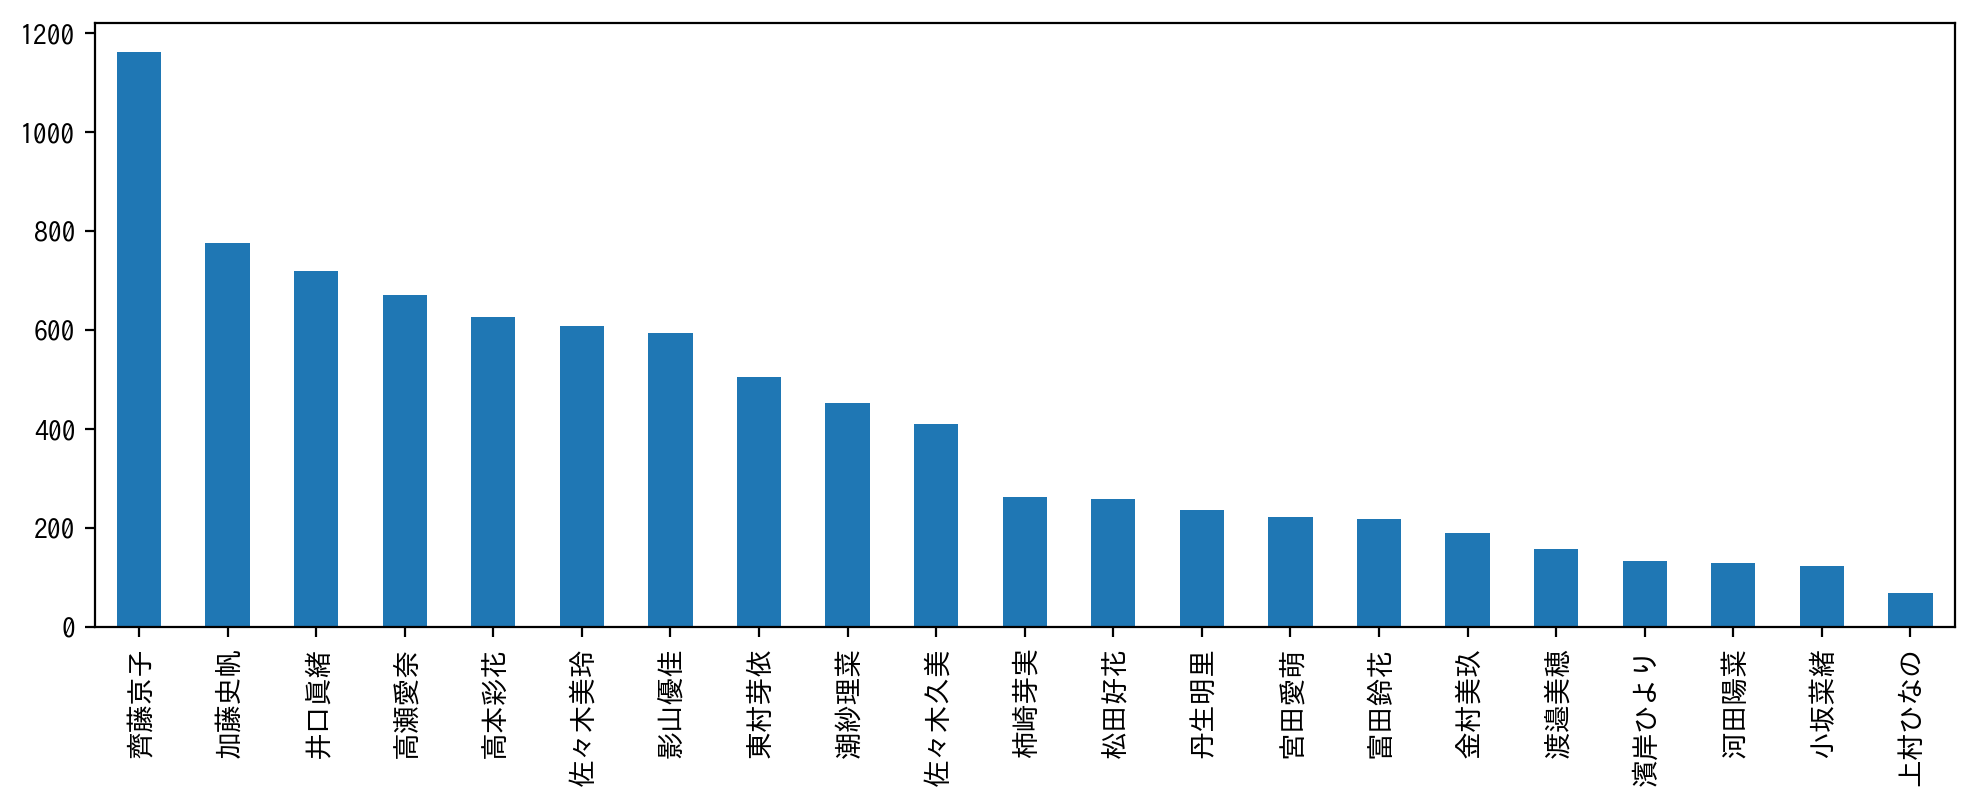

In [14]:
# plot article numbers each author

fig = plt.figure(figsize=(12,4),dpi=100)
df['author'].value_counts().plot(kind='bar')
plt.show()

In [15]:
author2tag = {}
for i in df['author'].unique().tolist(): # 漢字欅だけにしたいので500件のみ, 卒業メンバ含まない18名
    memwords = get_member_words(i)
    if len(memwords) == 0: continue
    author2tag[i] = memwords[0][1]
target_members_name = [ i for i in author2tag.keys() ]
target_members = [ i for i in author2tag.values() ]
mem2idx = { mem:idx for idx,mem in enumerate( target_members ) }

In [16]:
len(author2tag)

21

In [17]:
df_kanji = df[df['author'].isin( target_members_name )]
df_kanji_targetrange = extract_df_date_range(df_kanji, '2015-01-01', '2020-04-01')
dfmat = get_relation( df_kanji_targetrange )

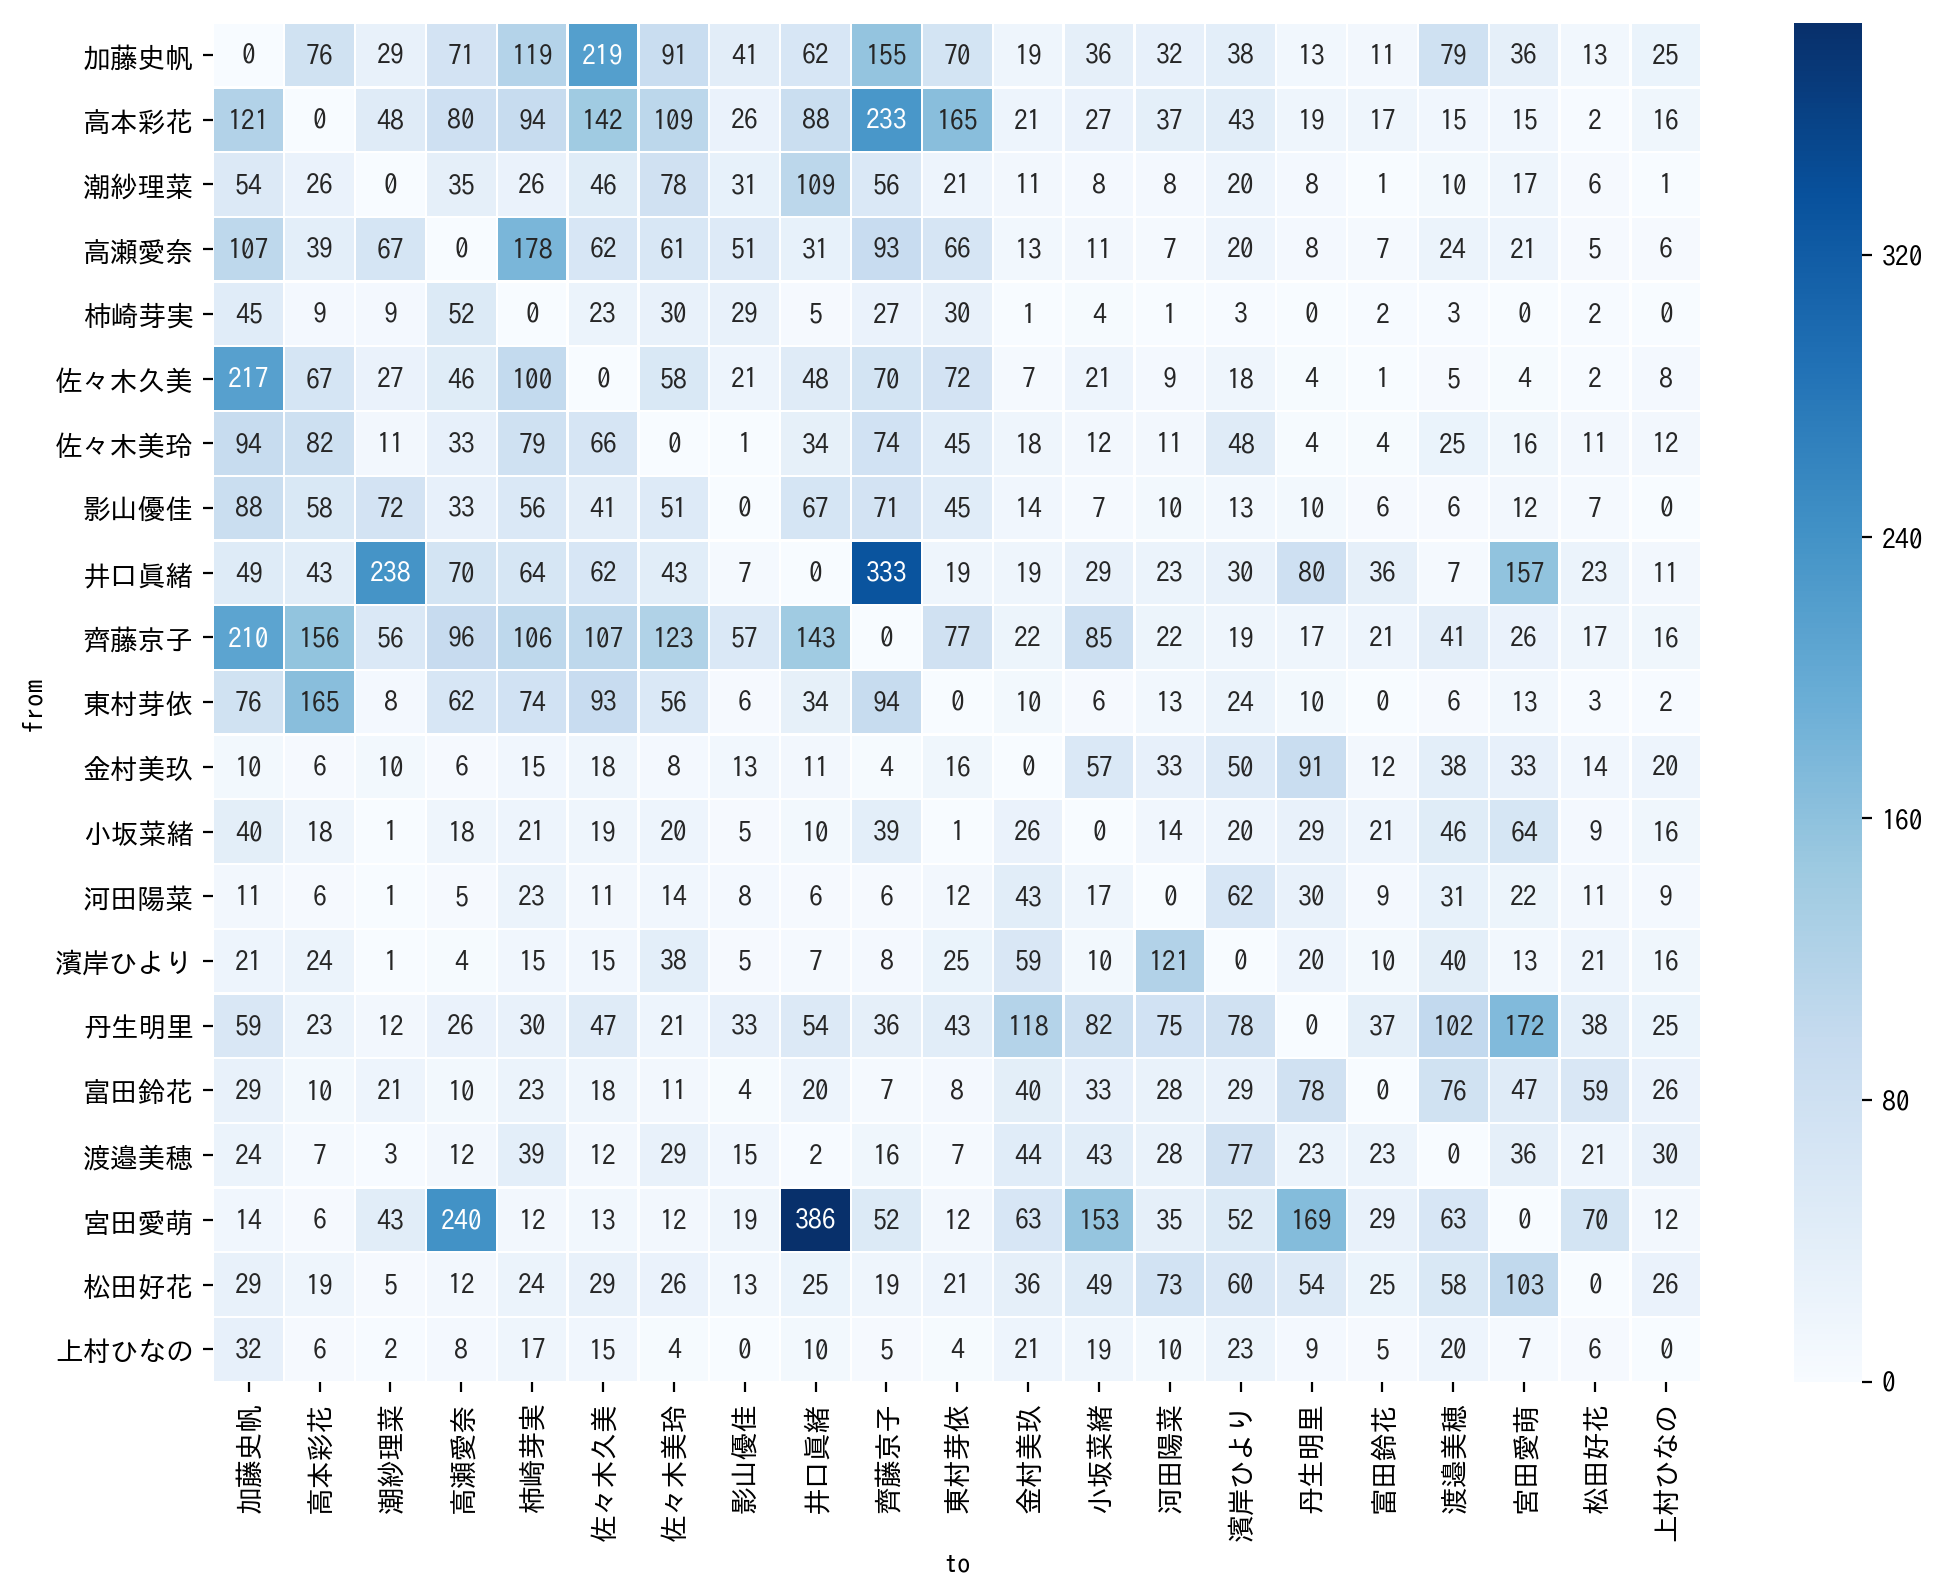

In [18]:
chech_heatmap(dfmat)

In [19]:
dfmat_mms_to = to_mms_for_df( dfmat )
dfmat_mms_from = from_mms_for_df( dfmat )

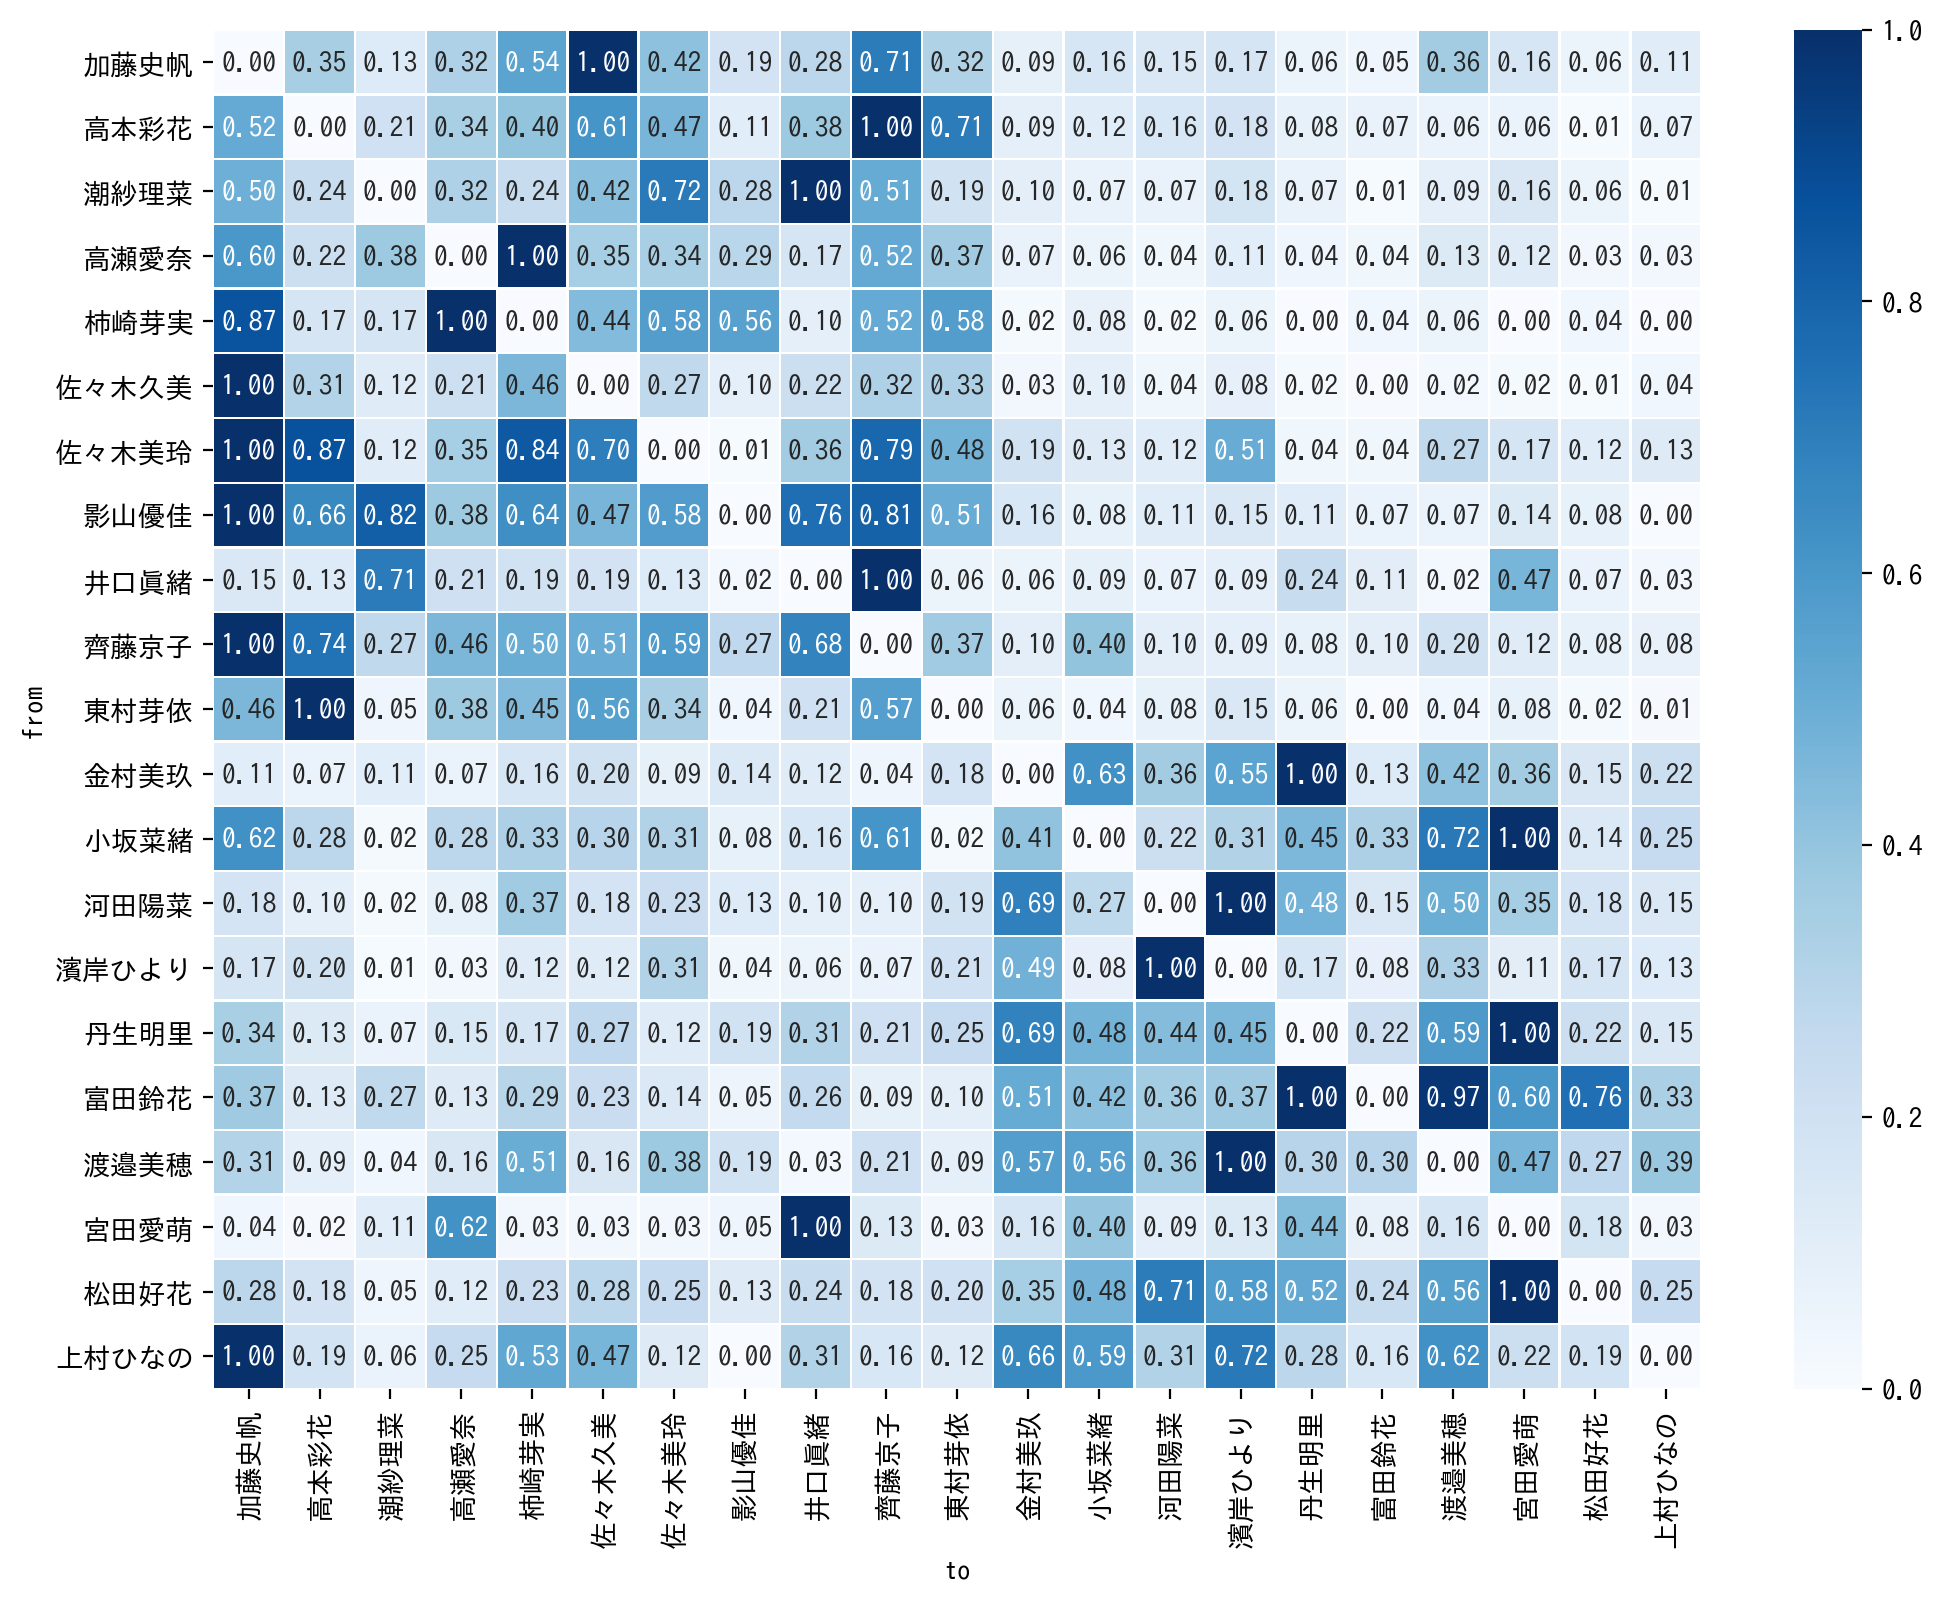

In [20]:
chech_heatmap_normarize( dfmat_mms_to )

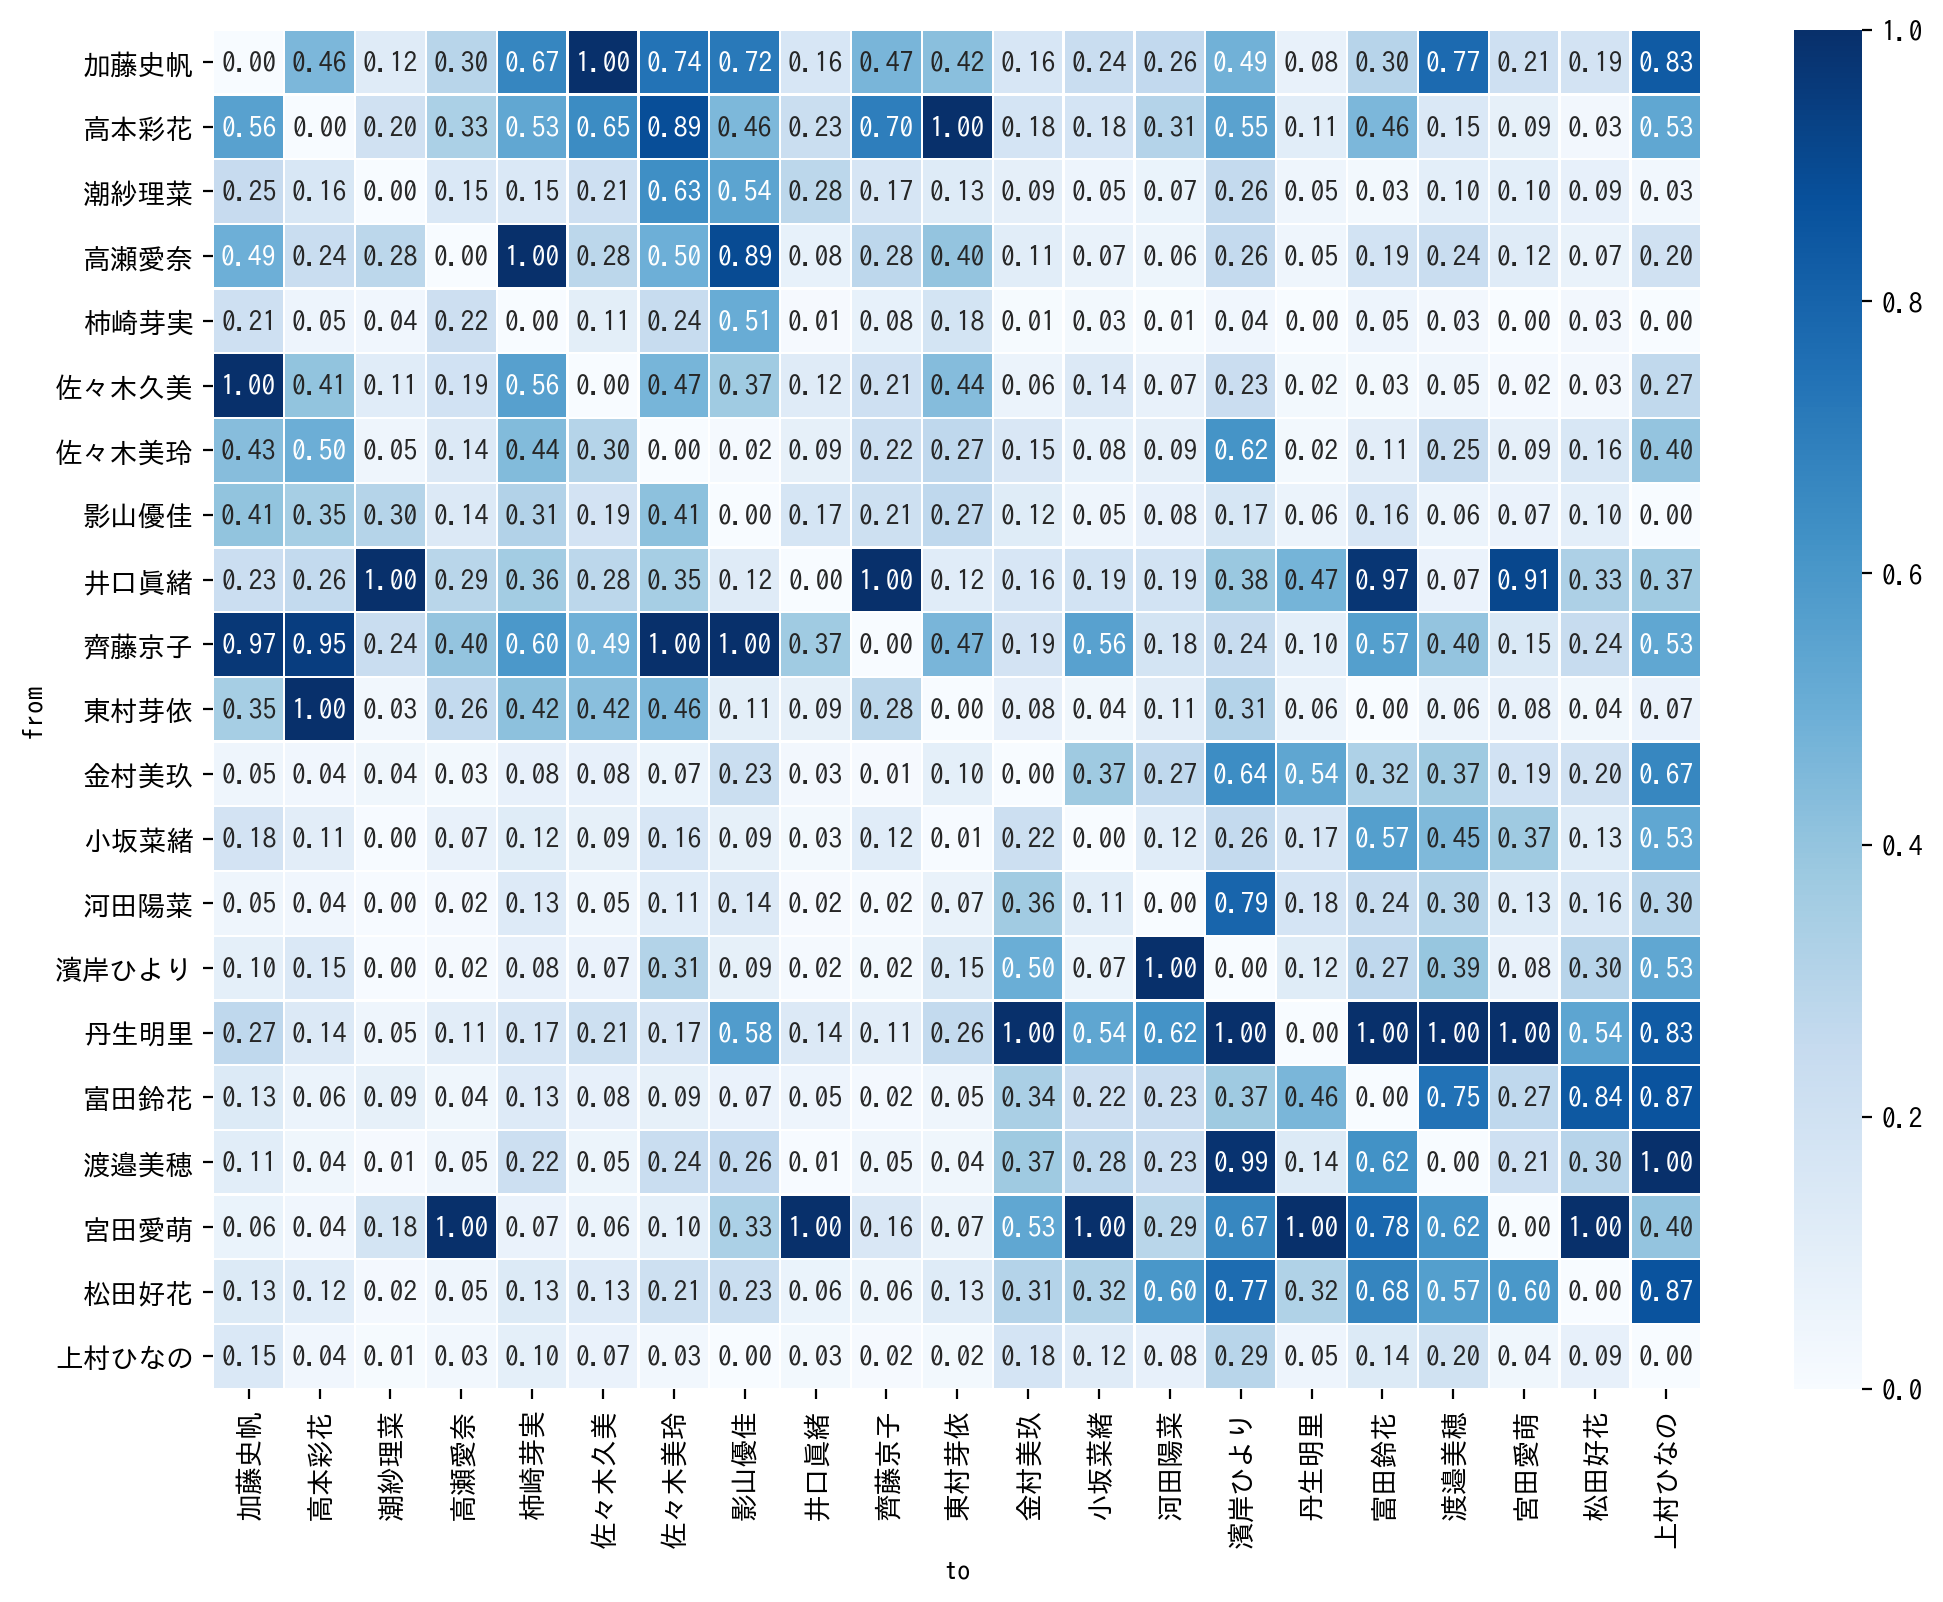

In [21]:
chech_heatmap_normarize( dfmat_mms_from )

In [22]:
neighbor_num = 3

targets = {}
for i in range( len( target_members ) ):
    mat = dfmat_mms_from.values
    sorted = np.argsort(mat[i])[::-1]
    sorted_val = np.sort(mat[i])[::-1]
    target = []
    for idx in range( neighbor_num ):
        target.append( (sorted[idx], sorted_val[idx]) )
    targets[i] = target

In [23]:
th = 0.6

targets = {}
for i in range( len( target_members ) ):
    mat = dfmat_mms_to.T.values
    sorted = np.argsort(mat[i])[::-1]
    sorted_val = np.sort(mat[i])[::-1]
    target = []
    for idx in range( len( sorted ) ):
        if sorted_val[idx] >= th:
            target.append( (sorted[idx], sorted_val[idx]) )
    targets[i] = target

In [24]:
G = nx.DiGraph()
for i, target in targets.items() :
    for j in target:
        G.add_edge(target_members_name[i],
                   target_members_name[j[0]],
                   weight=j[1])

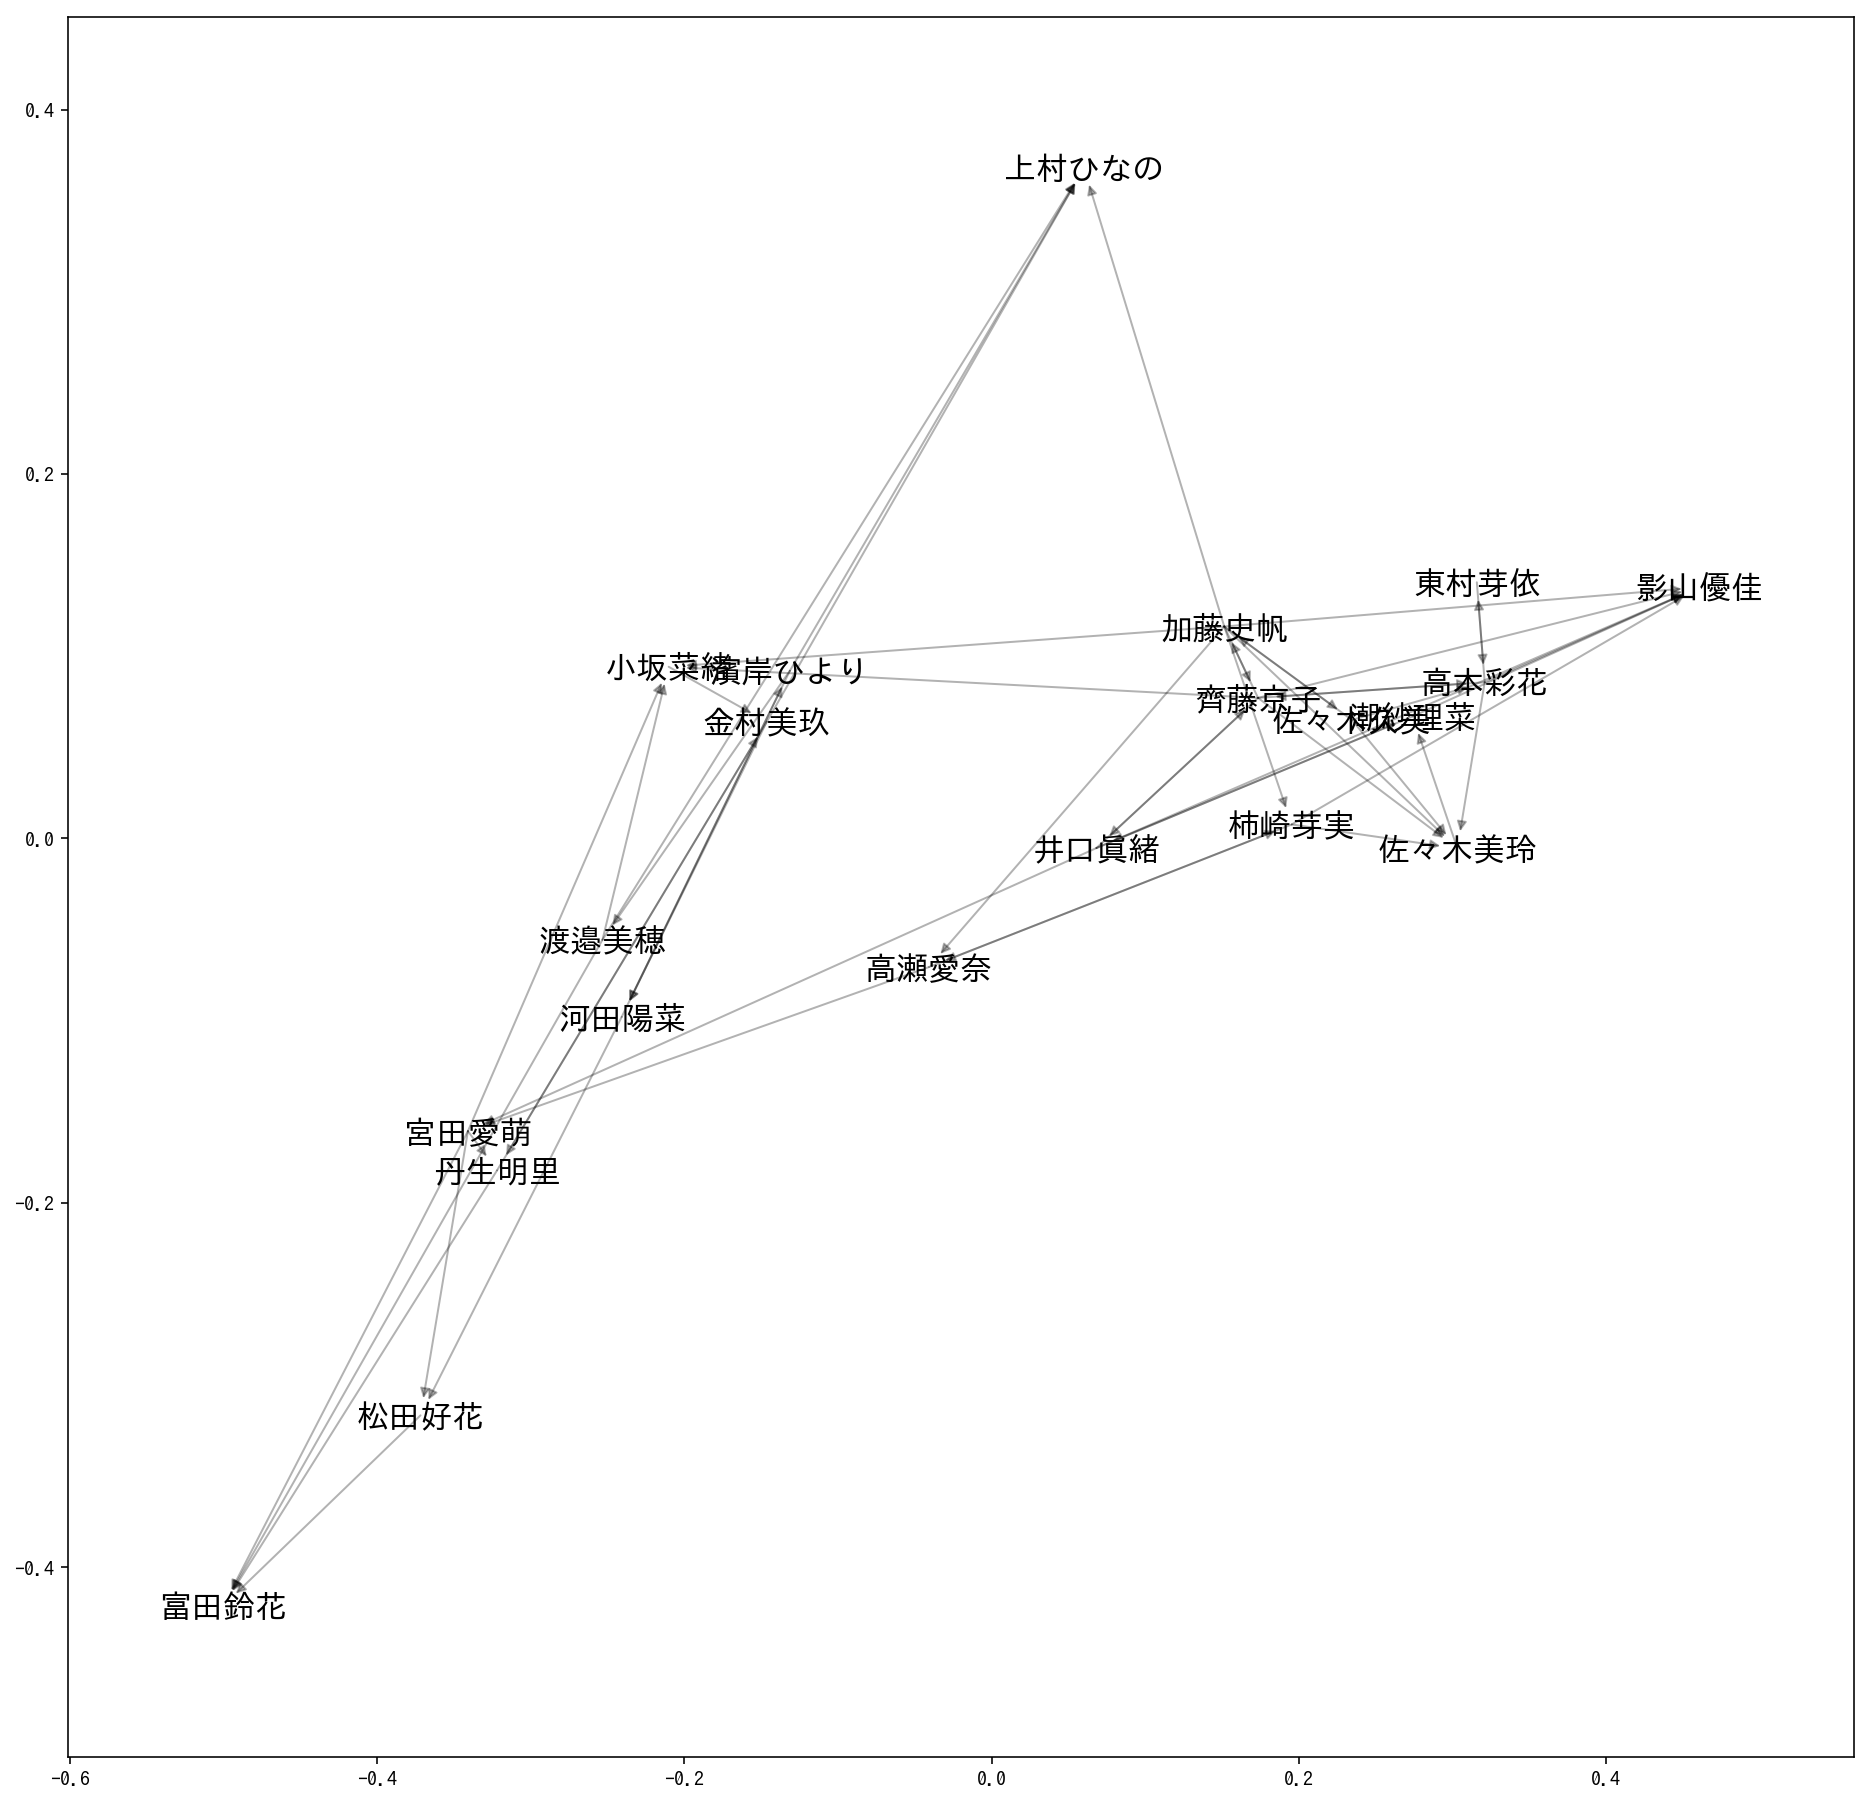

In [25]:
plt.figure(figsize=(16, 16))

pos=nx.spring_layout(G, scale=0.5)
nx.draw_networkx_edges(G, pos,alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=16, font_family='TakaoGothic')

plt.show()

In [27]:
targets = {}
for i in range( len( target_members ) ):
    mat = dfmat.T.values
    sorted = np.argsort(mat[i])[::-1]
    sorted_val = np.sort(mat[i])[::-1]
    target = []
    for idx in range( len( sorted ) ):
        target.append( (sorted[idx], sorted_val[idx]) )
    targets[i] = target

G = nx.DiGraph()
for i, target in targets.items() :
    for j in target:
        G.add_edge(target_members_name[i],
                   target_members_name[j[0]],
                   weight=j[1])

In [28]:
get_gdf_from_networkX( G, '%s/graph_Blog_hinata.gdf' % (graph_save_dir) )
get_gml_from_networkX( G, '%s/graph_Blog_hinata.gml' % (graph_save_dir))